# Return Optimization Training

#### Loading the data

In [41]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pickle

df = pd.read_csv("return_data.csv")
df.head()

,Reason,Condition,Days_since_order,Customer_type,Price_range,Action
0,no longer needed,like new,3,repeat,low,repurpose
1,wrong item,new,9,new,high,repurpose
2,defective,damaged,11,repeat,medium,recycle
3,no longer needed,new,2,new,high,restock
4,no longer needed,new,29,repeat,low,repurpose


#### Label Encoding - Mapping


In [42]:
Reason = {"defective": 0, "wrong size": 1, "wrong item": 2, "no longer needed": 3}
Condition = {"new": 0, "like new": 1, "damaged": 2}
Customer_type = {"new": 0, "repeat": 1}
Price_range = {"low": 0, "medium": 1, "high": 2}
action_map = {"restock": 0, "repurpose": 1, "recycle": 2, "reship": 3}


df["Reason"] = df["Reason"].map(Reason)
df["Condition"] = df["Condition"].map(Condition)
df["Customer_type"] = df["Customer_type"].map(Customer_type)
df["Price_range"] = df["Price_range"].map(Price_range)
df["Action"] = df["Action"].map(action_map)



#### Splitting the features (X) and labels (Y)

In [43]:
X = df[["Reason", "Condition", "Days_since_order", "Customer_type", "Price_range"]]
y = df["Action"]

#### Train test split

In [44]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)
print("Test: ", len(X_test))
print("Train: ",len(X_train))

Test:  100
Train:  400


#### Compute Class Weights ---


In [45]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, weights))
sample_weights = y_train.map(class_weights_dict)

#### Grid Search for Best Model ---


In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV

params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=params,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train, sample_weight=sample_weights)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/akshu/Documents/CODES/Projects/Walmart/.conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:57:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/akshu/Documents/CODES/Projects/Walmart/.conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:57:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/akshu/Documents/CODES/Projects/Walmart/.conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:57:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/akshu/Documents/CODES/Projects/Walmart/.conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:57:

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200], 'subsample': [0.8, 1.0]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


#### Training the model

#### Evaluate Best Model ---


In [47]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
action_names = ["restock", "repurpose", "recycle", "reship"]

print("\n✅ Best Parameters:", grid.best_params_)
print(f"✅ Accuracy on Test Set: {accuracy:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=action_names))


✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
✅ Accuracy on Test Set: 0.7800

📊 Classification Report:
              precision    recall  f1-score   support

     restock       0.65      0.55      0.59        20
   repurpose       0.86      0.86      0.86        29
     recycle       0.86      0.91      0.89        35
      reship       0.59      0.62      0.61        16

    accuracy                           0.78       100
   macro avg       0.74      0.74      0.74       100
weighted avg       0.78      0.78      0.78       100



In [ ]:
# # --- 6. Train Model with Sample Weights ---
# model = XGBClassifier(
#     max_depth=5,
#     n_estimators=200,
#     learning_rate=0.05,
#     use_label_encoder=False,
#     eval_metric='mlogloss',
#     random_state=42
# )
# model.fit(X_train, y_train, sample_weight=sample_weights)


/Users/akshu/Documents/CODES/Projects/Walmart/.conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [24]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# classes = np.unique(y_train)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# class_weights_dict = dict(zip(classes, weights))


In [25]:
# model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
# sample_weights = y_train.map(lambda x: class_weights_dict[x])
# model.fit(X_train, y_train, sample_weight=sample_weights)


In [26]:
# from sklearn.dummy import DummyClassifier

# dummy = DummyClassifier(strategy="most_frequent")
# dummy.fit(X_train, y_train)
# print("Dummy test accuracy:", dummy.score(X_test, y_test))


In [27]:
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier()
# model.fit(X_train, y_train)


#### Accuracy

In [48]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")

✅ Accuracy: 0.7800


#### CRoss validation

In [49]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X, y, cv=5)

print("Fold-wise scores:", scores)
print("Average CV accuracy:", scores.mean())


/Users/akshu/Documents/CODES/Projects/Walmart/.conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/akshu/Documents/CODES/Projects/Walmart/.conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/akshu/Documents/CODES/Projects/Walmart/.conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:58:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/akshu/Documents/CODES/Projects/Walmart/.conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:58:

Fold-wise scores: [0.72 0.73 0.78 0.83 0.76]
Average CV accuracy: 0.764


#### Classification report

In [30]:
from sklearn.metrics import classification_report

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["restock", "repurpose", "recycle", "reship"]))



📊 Classification Report:
              precision    recall  f1-score   support

     restock       0.79      0.55      0.65        20
   repurpose       0.83      0.86      0.85        29
     recycle       0.82      0.89      0.85        35
      reship       0.61      0.69      0.65        16

    accuracy                           0.78       100
   macro avg       0.76      0.75      0.75       100
weighted avg       0.78      0.78      0.78       100



- Checking prediction

In [50]:
for test_input, actual in zip(X_test.values[:10], y_test[:10]):
    pred = best_model.predict([test_input])[0]
    print(f"Input: {test_input}, Predicted: {pred}, Actual: {actual}")


Input: [3 2 4 0 0], Predicted: 1, Actual: 1
Input: [ 2  2 26  0  1], Predicted: 2, Actual: 2
Input: [ 0  2 30  0  1], Predicted: 2, Actual: 2
Input: [2 2 4 0 0], Predicted: 2, Actual: 2
Input: [ 2  0 13  1  0], Predicted: 3, Actual: 1
Input: [2 2 2 0 0], Predicted: 2, Actual: 2
Input: [ 2  2 23  1  1], Predicted: 2, Actual: 2
Input: [ 1  1 28  1  0], Predicted: 0, Actual: 1
Input: [ 0  1 10  0  0], Predicted: 1, Actual: 1
Input: [ 0  2 19  0  0], Predicted: 2, Actual: 2


#### Confusion Matrix

Text(95.72222222222221, 0.5, 'Truth')

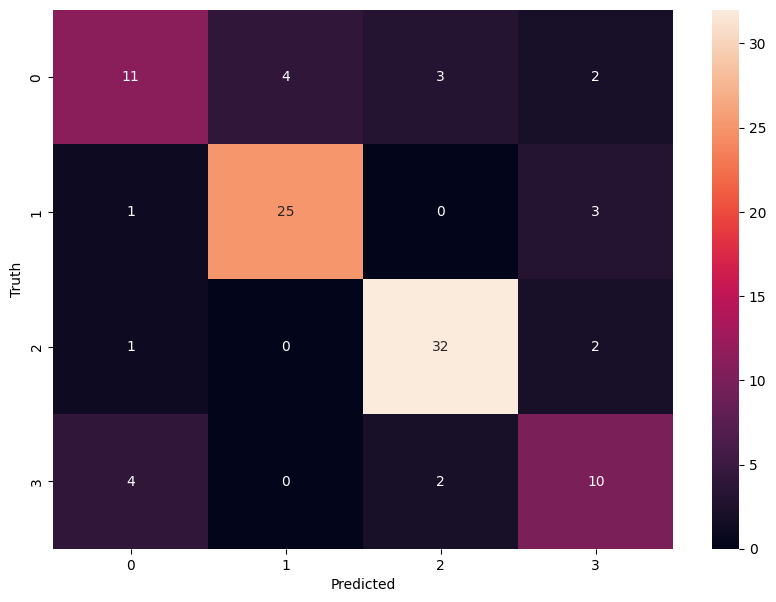

In [51]:
y_predicted = best_model.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_predicted)
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [52]:
df["Action"].value_counts(normalize=True)


Action
1    0.356
2    0.300
0    0.172
3    0.172
Name: proportion, dtype: float64

In [53]:
# --- 9. Confidence Scores ---
probs = best_model.predict_proba(X_test)
confidences = probs.max(axis=1)

confident_preds = np.where(confidences > 0.8, y_pred, -1)
print("\n🔐 Predictions with Confidence > 80% (others marked -1):")
print(confident_preds[:10])


🔐 Predictions with Confidence > 80% (others marked -1):
[ 1  2  2  2  3  2  2 -1 -1  2]


In [54]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")

✅ Accuracy: 0.7800


#### Save the Model ---


In [55]:
with open("final_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("💾 Model saved as final_xgb_model.pkl")

💾 Model saved as final_xgb_model.pkl
